In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset and Initial Data Inspection

In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  str    
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  str    
 5   Gender           10000 non-null  str    
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), str(3)
memory usage: 1.1 MB


In [38]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Part 1: Data Splitting & Anti-Leakage Setup
<span style="font-size: 18px;">
The dataset is splitted into 80:20 split for train and test so that test data has no idea about train data and no data leakage would happen.
</span>

In [6]:
X = df.drop("Exited",axis=1)
y = df["Exited"]

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state = 42,stratify =y)

In [7]:
X_train.shape

(8000, 13)

<span style="font-size: 18px;">
Columns such has RowNumber, CustomerId and Surname do not play any role in predicting the outcome hence are removed in the starting
</span>

In [8]:
drop_columns = ['RowNumber','CustomerId','Surname']
X_train = X_train.drop(columns=drop_columns)
X_test = X_test.drop(columns = drop_columns)

## Exploratory Data Analysis

<span style="font-size: 18px;">
EDA is performed to understand the relation between different columns and targeted value. A copy of training dataset is made and target column is attached to perform the EDA,so that the original training data remains unaltered.
</span>

In [9]:
train_df = X_train.copy()
train_df["Exited"] = y_train

In [10]:
train_df["Exited"].value_counts(normalize=True)*100

Exited
0    79.625
1    20.375
Name: proportion, dtype: float64

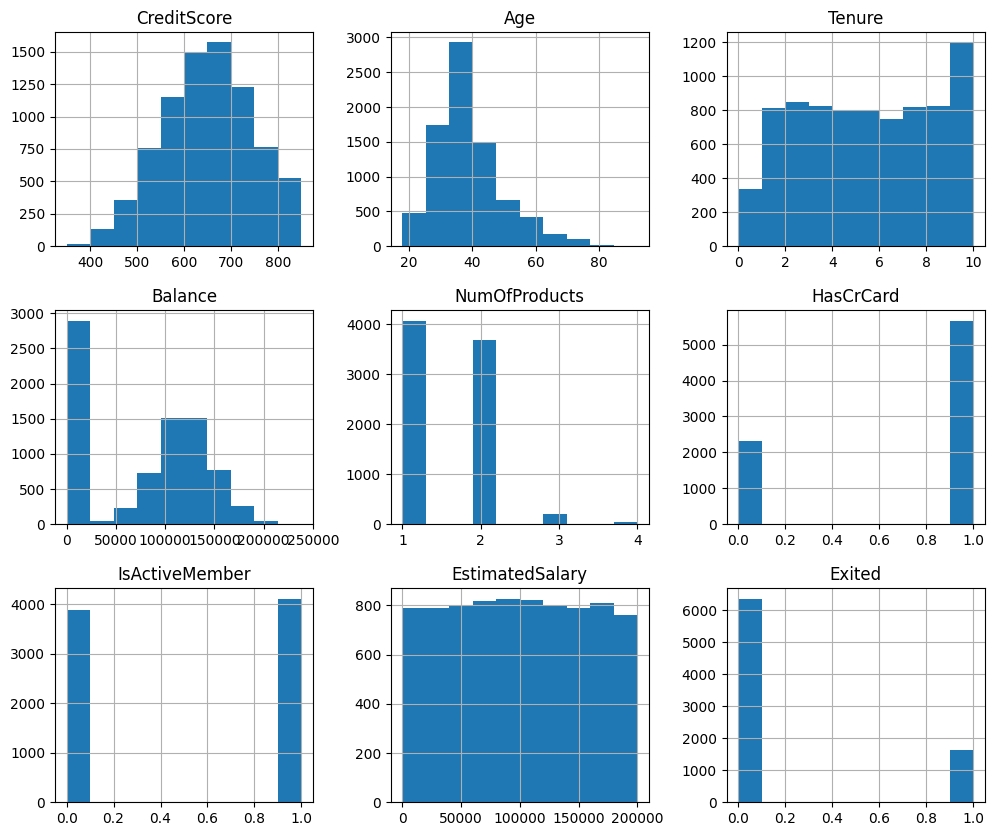

In [11]:
nums_col = train_df.select_dtypes(include=['int64','float64']).columns
train_df[nums_col].hist(figsize=(12,10))
plt.show()

<Axes: xlabel='Exited', ylabel='Age'>

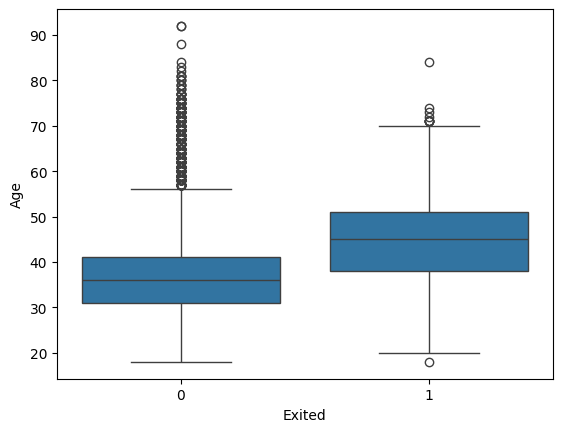

In [12]:
sns.boxplot(x="Exited",y="Age",data = train_df)

In [13]:
pd.crosstab(train_df["Geography"],train_df["Exited"],normalize = "index")

Exited,0,1
Geography,,
France,0.840972,0.159028
Germany,0.669327,0.330673
Spain,0.834166,0.165834


In [14]:
pd.crosstab(train_df["Gender"],train_df["Exited"],normalize = "index")

Exited,0,1
Gender,,
Female,0.749239,0.250761
Male,0.834967,0.165033


In [15]:
pd.crosstab(train_df["NumOfProducts"],train_df["Exited"],normalize = "index")

Exited,0,1
NumOfProducts,,
1,0.720216,0.279784
2,0.926198,0.073802
3,0.178744,0.821256
4,0.000000,1.000000


In [16]:
pd.crosstab(train_df["IsActiveMember"],train_df["Exited"],normalize = "index")

Exited,0,1
IsActiveMember,,
0,0.733058,0.266942
1,0.855790,0.144210


In [17]:
pd.crosstab(train_df["HasCrCard"],train_df["Exited"],normalize = "index")

Exited,0,1
HasCrCard,,
0,0.787124,0.212876
1,0.800000,0.200000


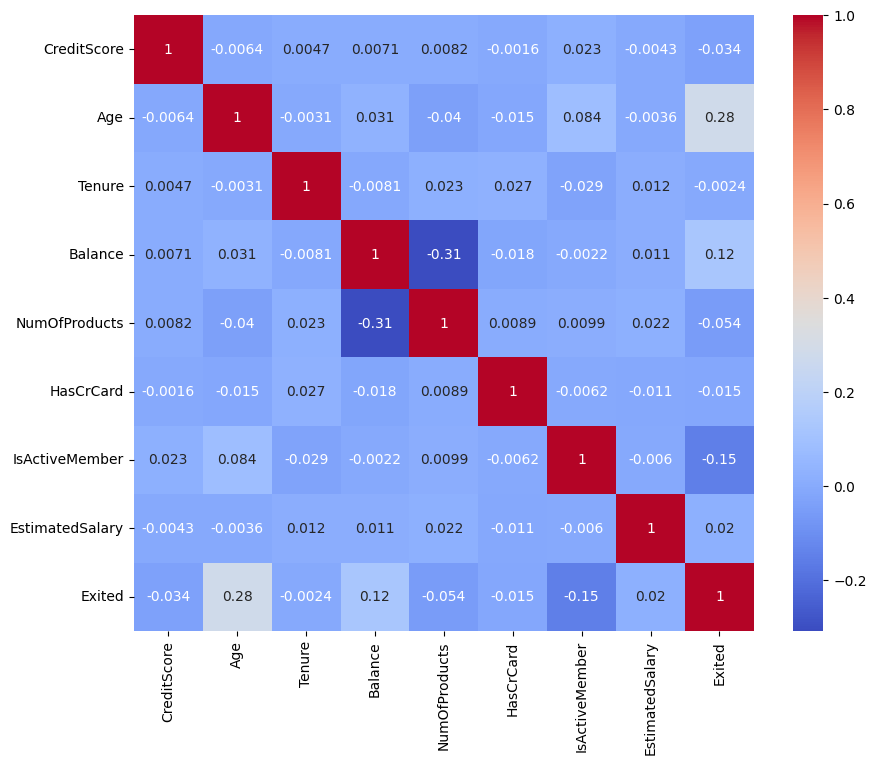

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df[nums_col].corr(), annot=True, cmap="coolwarm")
plt.show()

<span style="font-size: 18px;">
Exploratory Data Analysis was performed exclusively on the training dataset to avoid data leakage. The target variable showed class imbalance, with approximately 20% churned customers. Analysis of categorical features revealed higher churn rates among inactive members and having germany as geographic region. Numerical feature inspection indicated that older customers and those with fewer products were more likely to churn. Correlation analysis showed moderate relationships with churn, suggesting that tree-based models would effectively capture non-linear patterns in the data.
</span>

## Part 2: Feature Engineering & Preprocessing

In [19]:
# Feature engineering 
# Balance per product
X_train["Balance_per_Product"] = (X_train["Balance"] / X_train["NumOfProducts"])

# Tenure per age
X_train["Tenure_per_Age"] = (X_train["Tenure"] / X_train["Age"])

# Activity x Balance Interaction
X_train["Activity_Balance"] = (X_train["IsActiveMember"] * X_train["Balance"])

In [20]:
X_train["Gender"] = X_train["Gender"].map({"Male": 1, "Female": 0})
X_train = pd.get_dummies(X_train, columns=["Geography"], drop_first=True)

In [21]:
X_train.shape

(8000, 14)

In [22]:
nums_col_new = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary','Balance_per_Product','Tenure_per_Age','Activity_Balance']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit ONLY on train
X_train[nums_col_new] = scaler.fit_transform(X_train[nums_col_new])

<span style="font-size: 18px;">
Feature engineering was performed to capture deeper behavioral patterns beyond the raw features. New interaction features such as Balance_per_Product were created to understand how account balance is distributed across a customer’s products, which may indicate engagement level. Tenure_per_Age was introduced to reflect customer loyalty relative to age, while Activity_Balance captures the relationship between account activity and balance size, highlighting potentially disengaged high-value customers.


Categorical variables were handled appropriately: Gender was converted into binary format, and Geography was encoded using One-Hot Encoding using pd.get_dummies to allow the model to learn regional differences without implying ordinal relationships.

Finally, continuous numerical features were scaled using StandardScaler to ensure consistent magnitude across variables. Scaling was applied only to numerical columns and was fit exclusively on the training data to prevent data leakage.
</span> 

## Part 3: Model Developement

<span style="font-size: 18px;">
Since the model was trained on engineered, encoded, and scaled features, the test data had to undergo the exact same transformations before evaluation. A preprocessing function was created to generate the new features, encode categorical variables, align the test columns with the training structure, and apply the previously fitted scaler. Importantly, the scaler was only used to transform the test data (not refit), ensuring a fair and leakage-free evaluation.
</span>

In [24]:
def preprocess_test_data(X_test, X_train_columns, scaler, num_cols):
    
    X_test = X_test.copy()
    
    X_test["Balance_per_Product"] = (
        X_test["Balance"] / X_test["NumOfProducts"]
    )
    
    X_test["Tenure_per_Age"] = (
        X_test["Tenure"] / X_test["Age"]
    )
    
    X_test["Activity_Balance"] = (
        X_test["IsActiveMember"] * X_test["Balance"]
    )
    
    X_test["Gender"] = X_test["Gender"].map({"Male": 1, "Female": 0})
    
    
    X_test = pd.get_dummies(X_test, columns=["Geography"], drop_first=True)
    
    X_test = X_test.reindex(columns=X_train_columns, fill_value=0)
    
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    
    return X_test

X_test_processed = preprocess_test_data(
    X_test,
    X_train.columns,
    scaler,
    nums_col_new
)

### Dummy Classifier

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_dummy_pred = dummy.predict(X_test_processed)

print("Dummy Accuracy:", accuracy_score(y_test, y_dummy_pred))

Dummy Accuracy: 0.7965


### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model_dt = DecisionTreeClassifier(max_depth=3,random_state=42)

model_dt.fit(X_train, y_train)

y_dt_pred = model_dt.predict(X_test_processed)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_dt_pred))
print(classification_report(y_test, y_dt_pred))

Decision Tree Accuracy: 0.838
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1593
           1       0.87      0.24      0.37       407

    accuracy                           0.84      2000
   macro avg       0.85      0.61      0.64      2000
weighted avg       0.84      0.84      0.80      2000



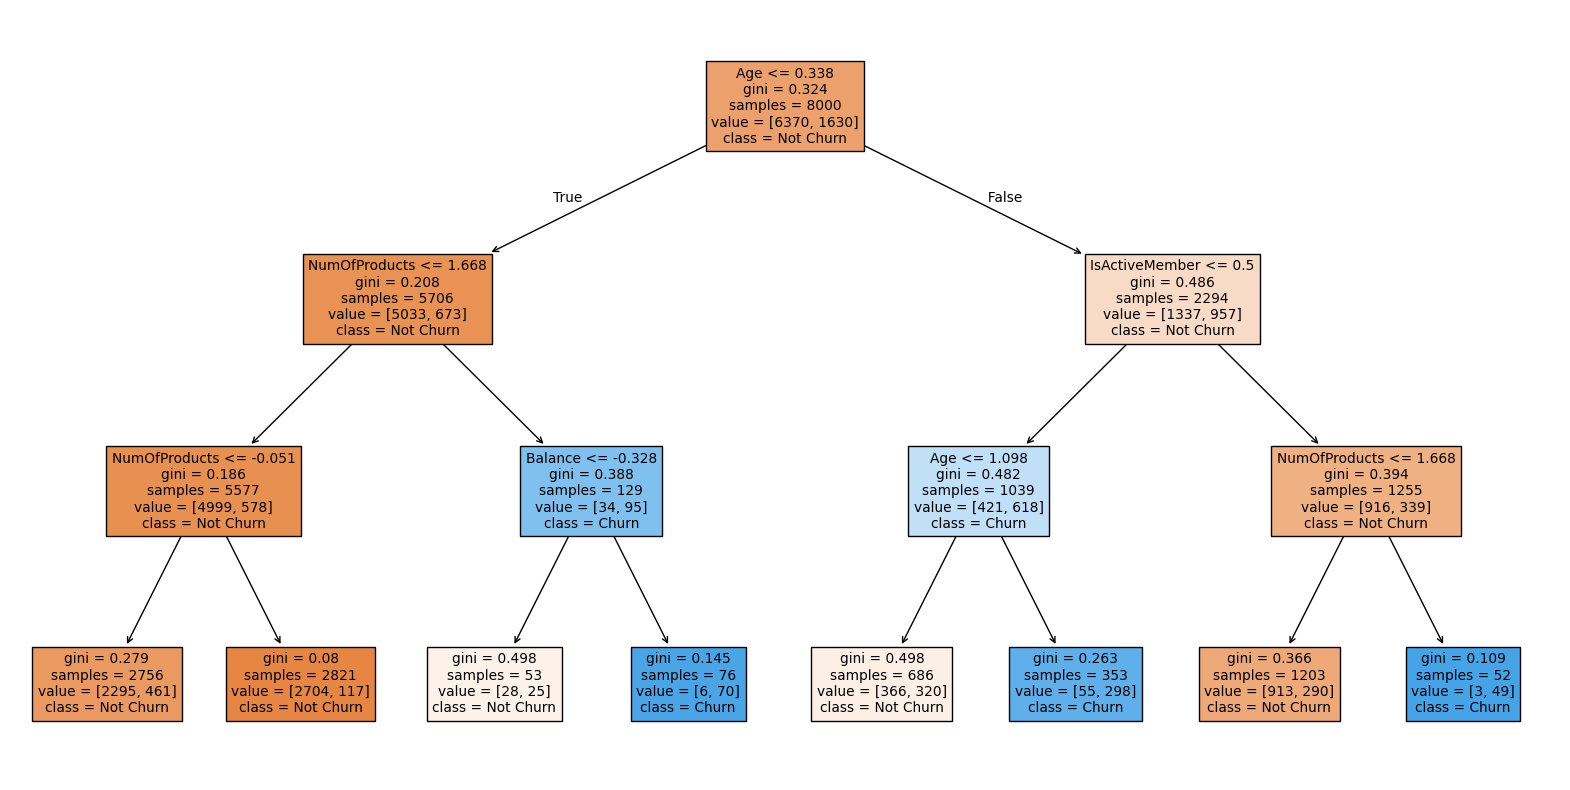

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    model_dt,
    feature_names=X_train.columns,
    class_names=["Not Churn", "Churn"],
    filled=True,
    max_depth=3
)
plt.show()

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)

y_rf_pred = rf.predict(X_test_processed)

print("Precision Score: ",precision_score(y_test,y_rf_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))

Precision Score:  0.7966804979253111
Random Forest Accuracy: 0.868
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



### LightGBM Model

In [34]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,precision_score

lgb = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,          # -1 means no limit
    random_state=42
)

lgb.fit(X_train, y_train)

y_lgb_pred = lgb.predict(X_test_processed)
y_lgb_prob = lgb.predict_proba(X_test_processed)[:, 1]

print("Precision Score: ",precision_score(y_test,y_lgb_pred))
print("LightGBM Accuracy:", accuracy_score(y_test, y_lgb_pred))
print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_lgb_prob))
print(classification_report(y_test, y_lgb_pred))

[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
Precision Score:  0.7481481481481481
LightGBM Accuracy: 0.8635
LightGBM ROC-AUC: 0.851153156237902
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.50      0.60       407

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



### HyperParameter Tuning of LightGBM model using Randomized Search CV

In [30]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [-1, 5, 10],
    "num_leaves": [31, 50]
}

from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)

lgb_tuned = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state =42
)
lgb_tuned.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifie...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 5, ...], 'n_estimators': [100, 200, ...], 'num_leaves': [31, 50]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionc

In [31]:
print("Best Parameters:", lgb_tuned.best_params_)

best_lgb = lgb_tuned.best_estimator_

lgb_tuned_pred = best_lgb.predict(X_test_processed)
acc_lgb_tuned = accuracy_score(y_test, lgb_tuned_pred)
print("Tuned Accuracy:",acc_lgb_tuned)
print(classification_report(y_test,lgb_tuned_pred))

Best Parameters: {'num_leaves': 31, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05}
Tuned Accuracy: 0.866
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.76      0.50      0.60       407

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.85      2000



### Trying new threshold to imporve Recall

In [32]:
y_prob = best_lgb.predict_proba(X_test_processed)[:,1]


threshold = 0.35
y_pred_new = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.65      0.61      0.63       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.85      0.85      2000



<span style="font-size: 18px;">
A Dummy Classifier was first trained as a baseline. It simply predicts the majority class (Non-Churn), serving as a reference to verify that more advanced models are truly learning patterns rather than exploiting class imbalance.

The Decision Tree initially showed very high precision but extremely low recall for churn. This indicates that the model was very conservative in predicting churn — when it predicted churn, it was almost always correct, but it missed most actual churners. This behavior reflects high variance and overfitting to dominant patterns.

With Random Forest, precision slightly decreased while recall improved (~0.40). By averaging multiple trees, variance was reduced and the model generalized better, capturing more churn cases. Finally, LightGBM further improved recall by sequentially correcting previous errors, striking a better balance between bias and variance. Hyperparameter tuning with RandomizedSearchCV helped control model complexity, resulting in the best overall trade-off between precision and recall.

In this type of scenarios recall becomes an important factor in judging the model, because we need to reduce the false negative so that the model does not classify churn as non churn, hence we tried different threshold and lowering the threshold to 0.35 increases the recall.
</span>

## Part 5: Final Evaluation & Business Insights

In [33]:
y_prob = best_lgb.predict_proba(X_test_processed)[:, 1]

# Apply custom threshold
threshold = 0.35   # <-- change to your final chosen threshold
y_pred = (y_prob >= threshold).astype(int)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

print("Final Test Metrics (Tuned LightGBM + Threshold Adjustment)")
print("-----------------------------------------------------------")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

Final Test Metrics (Tuned LightGBM + Threshold Adjustment)
-----------------------------------------------------------
Accuracy : 0.853
Precision: 0.6482939632545932
Recall   : 0.6068796068796068
F1-Score : 0.6269035532994924
ROC-AUC  : 0.8592136049763168


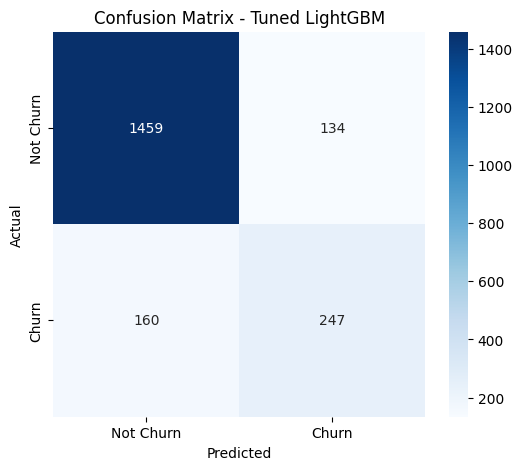

[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1619
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Churn", "Churn"],
            yticklabels=["Not Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned LightGBM")
plt.show()

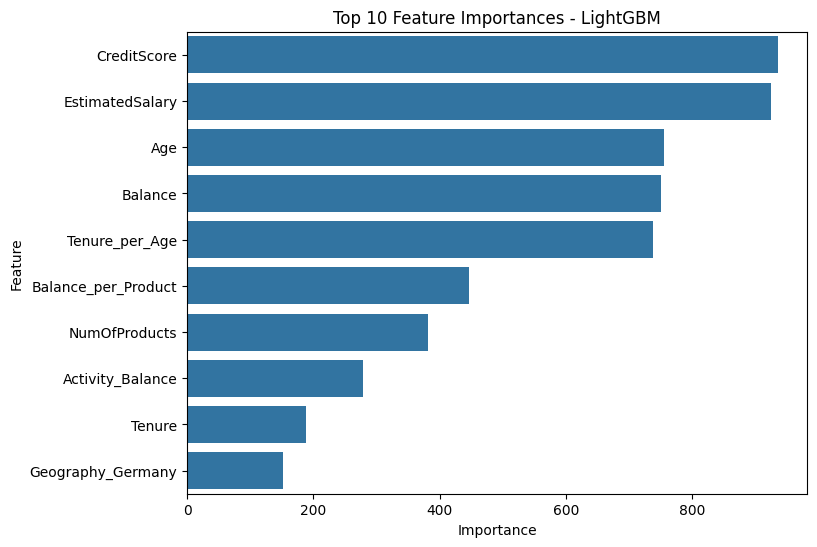

In [37]:
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_lgb.feature_importances_
})

feature_importance = feature_importance.sort_values(
    by="Importance", ascending=False
)

plt.figure(figsize=(8,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance.head(10)
)
plt.title("Top 10 Feature Importances - LightGBM")
plt.show()

<span style="font-size: 18px;">
The LightGBM model with tuned hyperparameters and new threshold when tested on the unseen test dataset gives the performance as - 
    Accuracy: 0.85
    Precision: 0.64 
    Recall: 0.60
    F1-Score: 0.62
    ROC-AUC: 0.86
    
While the accuracy improvement over baseline appears moderate, the key difference lies in churn detection. The model successfully identifies around 60% of churners, whereas the baseline model identifies none and the decision tree identifies 20%. This demonstrates that LightGBM is learning meaningful patterns rather than relying on class imbalance.
</span>

### Business Insights from feature importance
<span style="font-size: 18px;">
The feature importance plot shows that CreditScore, EstimatedSalary, Age, and Balance are the strongest predictors of churn. Age and balance-related features indicate that customer financial engagement plays a significant role in churn behavior.The new featured columns like Balance per product, Tenure per age and Activity Balance becomes important for prediction.

Customers who are older, have certain credit score ranges, hold higher balances but show lower activity, or maintain fewer products appear more likely to leave. Additionally, the presence of Geography_Germany among important features suggests regional differences in churn behavior.

For bank,the customers whom it should focus on can be :
- Older customers with moderate to high balance.
- Customer holding only 1 product
- Customer from germany geographical zone.
- Customers with low engagement despite high account value
</span>